# Example 4: 2nd-level Analysis

Last but not least, the 2nd-level analysis. After we removed left-handed subjects and normalized all subject data into template space, we can now do the group analysis. To show the flexibility of Nipype, we will run the group analysis on data with two different smoothing kernel (``fwhm= [4, 8]``) and two different normalizations (ANTs and SPM).

This example will also directly include thresholding of the output, as well as some visualization.

**Let's start!**

# Group Analysis with SPM

Let's first run the group analysis with the SPM normalized data.

## Imports (SPM12)

First, we need to import all the modules we later want to use.

In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


211107-15:35:12,464 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [2]:
experiment_dir = '/home/neuro/Result/Nipype_tutorial/working_dir'
output_dir = 'datasink'
working_dir = 'workingdir'

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005', 'con_0006', 'con_0007']

mask = "/home/neuro/Data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [3]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

stty: 'standard input': Inappropriate ioctl for device


## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [4]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir, 'norm_spm', 'sub-*_fwhm{fwhm_id}',
                         'w{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [5]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

211107-15:58:35,815 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/graph.png (graph2use=colored, simple_form=True).


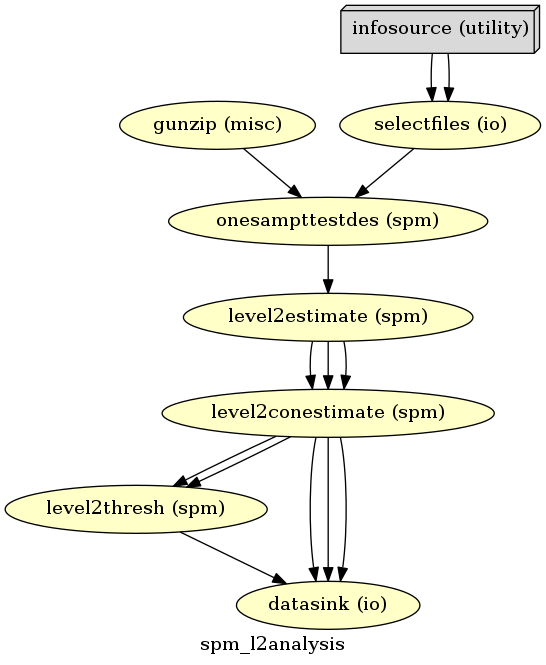

In [6]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [7]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

211107-15:58:54,258 nipype.workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
211107-15:58:54,423 nipype.workflow INFO:
	 Running in parallel.
211107-15:58:54,426 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 15 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:58:54,505 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/selectfiles".
211107-15:58:54,506 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_4/selectfiles".
211107-15:58:54,508 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_8/selectfiles".
211107-15:58:54,510 nipy

stty: 'standard input': Inappropriate ioctl for device


211107-15:59:08,4 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".
211107-15:59:08,33 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".
211107-15:59:08,33 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-15:59:08,438 nipype.workflow INFO:
	 [Job 15] Completed (spm_l2analysis.onesampttestdes).
211107-15:59:08,439 nipype.workflow INFO:
	 [Job 20] Completed (spm_l2analysis.onesampttestdes).
211107-15:59:08,440 nipype.workflow INFO:
	 [Job 25] Completed (spm_l2analysis.onesampttestdes).
211107-15:59:08,442 nipype.workflow INFO:
	 [Job 30] Completed (spm_l2analysis.onesampttestdes).
211107-15:59:08,443 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:59:08,502 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/level2estimate".
211107-15:59:08,504 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_4/level2estimate".
211107-15:59:08,505 nipype.wo

stty: 'standard input': Inappropriate ioctl for device


211107-15:59:31,553 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-15:59:31,614 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-15:59:31,626 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-15:59:32,477 nipype.workflow INFO:
	 [Job 16] Completed (spm_l2analysis.level2estimate).
211107-15:59:32,478 nipype.workflow INFO:
	 [Job 21] Completed (spm_l2analysis.level2estimate).
211107-15:59:32,479 nipype.workflow INFO:
	 [Job 26] Completed (spm_l2analysis.level2estimate).
211107-15:59:32,480 nipype.workflow INFO:
	 [Job 31] Completed (spm_l2analysis.level2estimate).
211107-15:59:32,481 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:59:32,534 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/level2conestimate".
211107-15:59:32,535 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_4/level2conestimate".
211107-15:59:32,537 n

stty: 'standard input': Inappropriate ioctl for device


211107-15:59:41,444 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211107-15:59:41,453 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211107-15:59:41,485 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-15:59:42,484 nipype.workflow INFO:
	 [Job 17] Completed (spm_l2analysis.level2conestimate).
211107-15:59:42,489 nipype.workflow INFO:
	 [Job 22] Completed (spm_l2analysis.level2conestimate).
211107-15:59:42,493 nipype.workflow INFO:
	 [Job 27] Completed (spm_l2analysis.level2conestimate).
211107-15:59:42,497 nipype.workflow INFO:
	 [Job 32] Completed (spm_l2analysis.level2conestimate).
211107-15:59:42,501 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:59:42,554 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/level2thresh".
211107-15:59:42,555 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_4/level2thresh".
211107-15:59:42,557 nipype.wo

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-15:59:48,474 nipype.workflow INFO:
	 [Job 18] Completed (spm_l2analysis.level2thresh).
211107-15:59:48,479 nipype.workflow INFO:
	 [Job 23] Completed (spm_l2analysis.level2thresh).
211107-15:59:48,484 nipype.workflow INFO:
	 [Job 28] Completed (spm_l2analysis.level2thresh).
211107-15:59:48,489 nipype.workflow INFO:
	 [Job 33] Completed (spm_l2analysis.level2thresh).
211107-15:59:48,492 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:59:48,544 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/datasink".
211107-15:59:48,546 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_4/datasink".
211107-15:59:48,548 nipype.workflow INFO:
	 [Node] Setting-up "sp

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-15:59:56,480 nipype.workflow INFO:
	 [Job 35] Completed (spm_l2analysis.onesampttestdes).
211107-15:59:56,481 nipype.workflow INFO:
	 [Job 40] Completed (spm_l2analysis.onesampttestdes).
211107-15:59:56,482 nipype.workflow INFO:
	 [Job 45] Completed (spm_l2analysis.onesampttestdes).
211107-15:59:56,483 nipype.workflow INFO:
	 [Job 50] Completed (spm_l2analysis.onesampttestdes).
211107-15:59:56,485 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:59:56,540 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/level2estimate".
211107-15:59:56,541 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/level2estimate".
211107-15:59:56,542 nipype.wo

stty: 'standard input': Inappropriate ioctl for device


211107-16:00:19,914 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-16:00:19,985 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-16:00:20,3 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:00:20,497 nipype.workflow INFO:
	 [Job 36] Completed (spm_l2analysis.level2estimate).
211107-16:00:20,498 nipype.workflow INFO:
	 [Job 41] Completed (spm_l2analysis.level2estimate).
211107-16:00:20,499 nipype.workflow INFO:
	 [Job 46] Completed (spm_l2analysis.level2estimate).
211107-16:00:20,499 nipype.workflow INFO:
	 [Job 51] Completed (spm_l2analysis.level2estimate).
211107-16:00:20,501 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:00:20,552 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/level2conestimate".
211107-16:00:20,553 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/level2conestimate".
211107-16:00:20,555 n

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:00:29,308 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211107-16:00:30,507 nipype.workflow INFO:
	 [Job 37] Completed (spm_l2analysis.level2conestimate).
211107-16:00:30,509 nipype.workflow INFO:
	 [Job 42] Completed (spm_l2analysis.level2conestimate).
211107-16:00:30,510 nipype.workflow INFO:
	 [Job 47] Completed (spm_l2analysis.level2conestimate).
211107-16:00:30,511 nipype.workflow INFO:
	 [Job 52] Completed (spm_l2analysis.level2conestimate).
211107-16:00:30,515 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:00:30,565 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/level2thresh".
211107-16:00:30,567 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workin

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:00:36,516 nipype.workflow INFO:
	 [Job 38] Completed (spm_l2analysis.level2thresh).
211107-16:00:36,520 nipype.workflow INFO:
	 [Job 43] Completed (spm_l2analysis.level2thresh).
211107-16:00:36,525 nipype.workflow INFO:
	 [Job 48] Completed (spm_l2analysis.level2thresh).
211107-16:00:36,531 nipype.workflow INFO:
	 [Job 53] Completed (spm_l2analysis.level2thresh).
211107-16:00:36,537 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:00:36,596 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/datasink".
211107-16:00:36,599 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/datasink".
211107-16:00:36,601 nipype.workflow INFO:
	 [Node] Setting-up "sp

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:00:44,523 nipype.workflow INFO:
	 [Job 55] Completed (spm_l2analysis.onesampttestdes).
211107-16:00:44,528 nipype.workflow INFO:
	 [Job 60] Completed (spm_l2analysis.onesampttestdes).
211107-16:00:44,534 nipype.workflow INFO:
	 [Job 65] Completed (spm_l2analysis.onesampttestdes).
211107-16:00:44,539 nipype.workflow INFO:
	 [Job 70] Completed (spm_l2analysis.onesampttestdes).
211107-16:00:44,544 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:00:44,601 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/level2estimate".
211107-16:00:44,603 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/level2estimate".
211107-16:00:44,604 nipype.wor

stty: 'standard input': Inappropriate ioctl for device


211107-16:01:07,253 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-16:01:07,291 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:01:07,419 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-16:01:08,544 nipype.workflow INFO:
	 [Job 56] Completed (spm_l2analysis.level2estimate).
211107-16:01:08,548 nipype.workflow INFO:
	 [Job 61] Completed (spm_l2analysis.level2estimate).
211107-16:01:08,553 nipype.workflow INFO:
	 [Job 66] Completed (spm_l2analysis.level2estimate).
211107-16:01:08,556 nipype.workflow INFO:
	 [Job 71] Completed (spm_l2analysis.level2estimate).
211107-16:01:08,557 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:01:08,611 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/level2conestimate".
211107-16:01:08,613 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/working

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:01:17,329 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211107-16:01:17,342 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211107-16:01:17,362 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device


211107-16:01:18,548 nipype.workflow INFO:
	 [Job 57] Completed (spm_l2analysis.level2conestimate).
211107-16:01:18,549 nipype.workflow INFO:
	 [Job 62] Completed (spm_l2analysis.level2conestimate).
211107-16:01:18,550 nipype.workflow INFO:
	 [Job 67] Completed (spm_l2analysis.level2conestimate).
211107-16:01:18,551 nipype.workflow INFO:
	 [Job 72] Completed (spm_l2analysis.level2conestimate).
211107-16:01:18,553 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:01:18,618 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/level2thresh".
211107-16:01:18,620 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/level2thresh".
211107-16:01:18,621 nipype.wor

stty: 'standard input': Inappropriate ioctl for device
stty: stty: 'standard input''standard input': Inappropriate ioctl for device
: Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:01:24,554 nipype.workflow INFO:
	 [Job 58] Completed (spm_l2analysis.level2thresh).
211107-16:01:24,555 nipype.workflow INFO:
	 [Job 63] Completed (spm_l2analysis.level2thresh).
211107-16:01:24,556 nipype.workflow INFO:
	 [Job 68] Completed (spm_l2analysis.level2thresh).
211107-16:01:24,557 nipype.workflow INFO:
	 [Job 73] Completed (spm_l2analysis.level2thresh).
211107-16:01:24,559 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:01:24,614 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/datasink".
211107-16:01:24,617 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/datasink".
211107-16:01:24,619 nipype.workflow INFO:
	 [Node] Setting-up "spm

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:01:32,563 nipype.workflow INFO:
	 [Job 75] Completed (spm_l2analysis.onesampttestdes).
211107-16:01:32,564 nipype.workflow INFO:
	 [Job 80] Completed (spm_l2analysis.onesampttestdes).
211107-16:01:32,565 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:01:32,617 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/level2estimate".
211107-16:01:32,619 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/level2estimate".
211107-16:01:32,654 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateModel")
211107-16:01:32,657 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.mo

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:01:50,580 nipype.workflow INFO:
	 [Job 76] Completed (spm_l2analysis.level2estimate).
211107-16:01:50,581 nipype.workflow INFO:
	 [Job 81] Completed (spm_l2analysis.level2estimate).
211107-16:01:50,583 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:01:50,635 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/level2conestimate".
211107-16:01:50,636 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/level2conestimate".
211107-16:01:50,730 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model.EstimateContrast")
211107-16:01:50,731 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipyp

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:01:58,587 nipype.workflow INFO:
	 [Job 77] Completed (spm_l2analysis.level2conestimate).
211107-16:01:58,593 nipype.workflow INFO:
	 [Job 82] Completed (spm_l2analysis.level2conestimate).
211107-16:01:58,600 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:01:58,663 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/level2thresh".
211107-16:01:58,664 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/level2thresh".
211107-16:01:58,753 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211107-16:01:58,753 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshol

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:02:02,590 nipype.workflow INFO:
	 [Job 78] Completed (spm_l2analysis.level2thresh).
211107-16:02:02,591 nipype.workflow INFO:
	 [Job 83] Completed (spm_l2analysis.level2thresh).
211107-16:02:02,592 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:02:02,647 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/datasink".
211107-16:02:02,649 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/datasink".
211107-16:02:02,681 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-16:02:02,682 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/_contrast_id_con_0001_fwhm_id_8/SPM

# Group Analysis with ANTs

Now to run the same group analysis, but on the ANTs normalized images, we just need to change a few parameters:

In [8]:
# Change the SelectFiles template and recreate the node
templates = {'cons': opj(output_dir, 'norm_ants', 'sub-*_fwhm{fwhm_id}',
                         '{contrast_id}_trans.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'ants_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

Now, we just have to recreate the workflow.

In [10]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='ants_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

And we can run it!

In [11]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

211107-16:02:53,592 nipype.workflow INFO:
	 Workflow ants_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
211107-16:02:53,745 nipype.workflow INFO:
	 Running in parallel.
211107-16:02:53,747 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 15 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:02:53,835 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/ants_l2analysis/_contrast_id_con_0007_fwhm_id_8/selectfiles".
211107-16:02:53,836 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/ants_l2analysis/_contrast_id_con_0007_fwhm_id_4/selectfiles".
211107-16:02:53,837 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/ants_l2analysis/_contrast_id_con_0006_fwhm_id_8/selectfiles".
211107-16:02:53,8

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:03:07,519 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".


stty: 'standard input': Inappropriate ioctl for device


211107-16:03:07,758 nipype.workflow INFO:
	 [Job 15] Completed (spm_l2analysis.onesampttestdes).
211107-16:03:07,759 nipype.workflow INFO:
	 [Job 20] Completed (spm_l2analysis.onesampttestdes).
211107-16:03:07,760 nipype.workflow INFO:
	 [Job 25] Completed (spm_l2analysis.onesampttestdes).
211107-16:03:07,761 nipype.workflow INFO:
	 [Job 30] Completed (spm_l2analysis.onesampttestdes).
211107-16:03:07,762 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:03:07,825 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:03:07,828 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/level2estimate".
211107-16:03:07,830 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:03:07,836 nipype.work

stty: 'standard input': Inappropriate ioctl for device


211107-16:03:43,789 nipype.workflow INFO:
	 [Job 31] Completed (spm_l2analysis.level2estimate).
211107-16:03:43,792 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:03:43,880 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:03:43,883 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_4/level2conestimate".
211107-16:03:43,885 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:03:44,33 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.mode

stty: 'standard input': Inappropriate ioctl for device


211107-16:03:45,790 nipype.workflow INFO:
	 [Job 26] Completed (spm_l2analysis.level2estimate).
211107-16:03:45,793 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:03:45,878 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:03:45,881 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_8/level2conestimate".
211107-16:03:45,883 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:03:45,965 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-16:

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:03:47,793 nipype.workflow INFO:
	 [Job 16] Completed (spm_l2analysis.level2estimate).
211107-16:03:47,794 nipype.workflow INFO:
	 [Job 21] Completed (spm_l2analysis.level2estimate).
211107-16:03:47,795 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 12 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211107-16:03:47,870 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:03:47,872 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/level2conestimate".
211107-16:03:47,875 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:03:47,883 nipype.workflow INFO:
	 [Node] Outdated

stty: 'standard input': Inappropriate ioctl for device


211107-16:03:53,797 nipype.workflow INFO:
	 [Job 32] Completed (spm_l2analysis.level2conestimate).
211107-16:03:53,799 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211107-16:03:53,867 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:03:53,870 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_4/level2thresh".
211107-16:03:53,873 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:03:54,5 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")


stty: 'standard input': Inappropriate ioctl for device


211107-16:03:55,800 nipype.workflow INFO:
	 [Job 27] Completed (spm_l2analysis.level2conestimate).
211107-16:03:55,802 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211107-16:03:55,886 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:03:55,890 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_8/level2thresh".
211107-16:03:55,892 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:03:56,37 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
2111

stty: 'standard input': Inappropriate ioctl for device


211107-16:03:57,221 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device


211107-16:03:57,799 nipype.workflow INFO:
	 [Job 17] Completed (spm_l2analysis.level2conestimate).
211107-16:03:57,801 nipype.workflow INFO:
	 [Job 22] Completed (spm_l2analysis.level2conestimate).
211107-16:03:57,802 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 12 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2thresh
211107-16:03:57,867 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:03:57,870 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/level2thresh".
211107-16:03:57,872 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:03:57,879 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2

stty: 'standard input': Inappropriate ioctl for device


211107-16:03:59,802 nipype.workflow INFO:
	 [Job 33] Completed (spm_l2analysis.level2thresh).
211107-16:03:59,804 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2thresh
211107-16:03:59,886 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:03:59,889 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_4/datasink".
211107-16:03:59,891 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:03:59,950 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-16:03:59,952 nipype.interface INFO:
	 s

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:01,803 nipype.workflow INFO:
	 [Job 28] Completed (spm_l2analysis.level2thresh).
211107-16:04:01,805 nipype.workflow INFO:
	 [Job 34] Completed (spm_l2analysis.datasink).
211107-16:04:01,806 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 11 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2thresh
211107-16:04:01,871 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:04:01,874 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0006_fwhm_id_8/datasink".
211107-16:04:01,876 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:04:01,885 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.onesampttestdes".
211

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:04:03,804 nipype.workflow INFO:
	 [Job 18] Completed (spm_l2analysis.level2thresh).
211107-16:04:03,805 nipype.workflow INFO:
	 [Job 23] Completed (spm_l2analysis.level2thresh).
211107-16:04:03,806 nipype.workflow INFO:
	 [Job 29] Completed (spm_l2analysis.datasink).
211107-16:04:03,807 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 11 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.onesampttestdes
211107-16:04:03,874 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:04:03,876 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0007_fwhm_id_8/datasink".
211107-16:04:03,878 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:04:03,887 nipype.workflow INFO:
	 [Node] Outdated cache fou

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:07,807 nipype.workflow INFO:
	 [Job 35] Completed (spm_l2analysis.onesampttestdes).
211107-16:04:07,809 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.onesampttestdes
                       * spm_l2analysis.onesampttestdes
                       * spm_l2analysis.onesampttestdes
211107-16:04:07,873 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:04:07,876 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/level2estimate".
211107-16:04:07,878 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:04:07,944 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateM

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:09,810 nipype.workflow INFO:
	 [Job 40] Completed (spm_l2analysis.onesampttestdes).
211107-16:04:09,811 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.onesampttestdes
                       * spm_l2analysis.onesampttestdes
211107-16:04:09,881 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:04:09,883 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/level2estimate".
211107-16:04:09,885 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:04:09,952 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.EstimateMo

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:04:11,812 nipype.workflow INFO:
	 [Job 45] Completed (spm_l2analysis.onesampttestdes).
211107-16:04:11,813 nipype.workflow INFO:
	 [Job 50] Completed (spm_l2analysis.onesampttestdes).
211107-16:04:11,815 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 8 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:04:11,881 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:04:11,884 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_8/level2estimate".
211107-16:04:11,886 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:04:11,892 nipype.workflow INFO:
	 [Node] Outdated cache found for 

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:39,837 nipype.workflow INFO:
	 [Job 36] Completed (spm_l2analysis.level2estimate).
211107-16:04:39,840 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:04:39,933 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:04:39,936 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/level2conestimate".
211107-16:04:39,938 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:04:40,144 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.mode

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:41,839 nipype.workflow INFO:
	 [Job 41] Completed (spm_l2analysis.level2estimate).
211107-16:04:41,841 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:04:41,920 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:04:41,923 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/level2conestimate".
211107-16:04:41,925 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:04:42,130 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.m

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:49,825 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-16:04:49,845 nipype.workflow INFO:
	 [Job 46] Completed (spm_l2analysis.level2estimate).
211107-16:04:49,846 nipype.workflow INFO:
	 [Job 51] Completed (spm_l2analysis.level2estimate).
211107-16:04:49,847 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 8 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211107-16:04:49,922 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:04:49,925 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_8/level2conestimate".
211107-16:04:49,927 nipype.workflow INFO:
	 [Node] Outdated cache found for "sp

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:50,96 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model.EstimateContrast")
211107-16:04:50,103 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211107-16:04:50,105 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model.EstimateContrast")


stty: 'standard input': Inappropriate ioctl for device


211107-16:04:51,847 nipype.workflow INFO:
	 [Job 37] Completed (spm_l2analysis.level2conestimate).
211107-16:04:51,849 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211107-16:04:51,918 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:04:51,922 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/level2thresh".
211107-16:04:51,924 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:04:51,926 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211107-16:04:52,28 

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:53,849 nipype.workflow INFO:
	 [Job 42] Completed (spm_l2analysis.level2conestimate).
211107-16:04:53,850 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211107-16:04:53,922 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:04:53,925 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/level2thresh".
211107-16:04:53,927 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:04:54,52 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
21110

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:57,852 nipype.workflow INFO:
	 [Job 38] Completed (spm_l2analysis.level2thresh).
211107-16:04:57,853 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211107-16:04:57,930 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:04:57,933 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_8/datasink".
211107-16:04:57,937 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:04:58,1 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-16:04:58,3 nipype.interface INFO

stty: 'standard input': Inappropriate ioctl for device


211107-16:04:59,116 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".
211107-16:04:59,134 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:04:59,854 nipype.workflow INFO:
	 [Job 47] Completed (spm_l2analysis.level2conestimate).
211107-16:04:59,855 nipype.workflow INFO:
	 [Job 52] Completed (spm_l2analysis.level2conestimate).
211107-16:04:59,856 nipype.workflow INFO:
	 [Job 43] Completed (spm_l2analysis.level2thresh).
211107-16:04:59,857 nipype.workflow INFO:
	 [Job 39] Completed (spm_l2analysis.datasink).
211107-16:04:59,859 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:04:59,930 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:04:59,932 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0005_fwhm_id_4/datasink".
211107-16:04:59,935 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:04:59,941 nipype.workflow INFO:
	 [Node] Outdated ca

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:05:05,339 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2thresh".
211107-16:05:05,649 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".


stty: 'standard input': Inappropriate ioctl for device


211107-16:05:05,858 nipype.workflow INFO:
	 [Job 48] Completed (spm_l2analysis.level2thresh).
211107-16:05:05,859 nipype.workflow INFO:
	 [Job 53] Completed (spm_l2analysis.level2thresh).
211107-16:05:05,860 nipype.workflow INFO:
	 [Job 55] Completed (spm_l2analysis.onesampttestdes).
211107-16:05:05,863 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 7 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.onesampttestdes
211107-16:05:05,935 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:05:05,939 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_8/datasink".
211107-16:05:05,941 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:05:05,951 nipype.workflow INFO:
	 [Node] Outdated cac

stty: 'standard input': Inappropriate ioctl for device


211107-16:05:07,860 nipype.workflow INFO:
	 [Job 60] Completed (spm_l2analysis.onesampttestdes).
211107-16:05:07,861 nipype.workflow INFO:
	 [Job 49] Completed (spm_l2analysis.datasink).
211107-16:05:07,862 nipype.workflow INFO:
	 [Job 54] Completed (spm_l2analysis.datasink).
211107-16:05:07,864 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 5 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
211107-16:05:07,940 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:05:07,943 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/level2estimate".
211107-16:05:07,945 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:05:07,956 nipype.workflow INFO:
	 [Nod

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:05:13,865 nipype.workflow INFO:
	 [Job 65] Completed (spm_l2analysis.onesampttestdes).
211107-16:05:13,867 nipype.workflow INFO:
	 [Job 70] Completed (spm_l2analysis.onesampttestdes).
211107-16:05:13,868 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 4 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:05:13,944 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:05:13,947 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0002_fwhm_id_8/level2estimate".
211107-16:05:13,949 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:05:13,956 nipype.workflow INFO:
	 [Node] Outdated cache found for 

stty: 'standard input': Inappropriate ioctl for device


211107-16:05:33,883 nipype.workflow INFO:
	 [Job 56] Completed (spm_l2analysis.level2estimate).
211107-16:05:33,885 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:05:33,951 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:05:33,954 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/level2conestimate".
211107-16:05:33,957 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:05:34,82 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model

stty: 'standard input': Inappropriate ioctl for device


211107-16:05:35,884 nipype.workflow INFO:
	 [Job 61] Completed (spm_l2analysis.level2estimate).
211107-16:05:35,886 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:05:35,954 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:05:35,956 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/level2conestimate".
211107-16:05:35,958 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:05:36,87 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.mo

stty: 'standard input': Inappropriate ioctl for device


211107-16:05:43,889 nipype.workflow INFO:
	 [Job 57] Completed (spm_l2analysis.level2conestimate).
211107-16:05:43,891 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:05:43,965 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:05:43,967 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/level2thresh".
211107-16:05:43,969 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:05:44,112 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
21110

stty: 'standard input': Inappropriate ioctl for device


211107-16:05:45,891 nipype.workflow INFO:
	 [Job 62] Completed (spm_l2analysis.level2conestimate).
211107-16:05:45,894 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:05:45,979 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:05:45,982 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/level2thresh".
211107-16:05:45,985 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:05:46,176 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211107-16:

stty: 'standard input': Inappropriate ioctl for device


211107-16:05:49,893 nipype.workflow INFO:
	 [Job 58] Completed (spm_l2analysis.level2thresh).
211107-16:05:49,895 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:05:49,962 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:05:49,966 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8/datasink".
211107-16:05:49,968 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:05:50,445 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-16:05:50,447 nipype.interface INFO:


stty: 'standard input': Inappropriate ioctl for device


211107-16:05:53,897 nipype.workflow INFO:
	 [Job 63] Completed (spm_l2analysis.level2thresh).
211107-16:05:53,899 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 2 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.onesampttestdes
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:05:53,989 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:05:53,992 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_4/datasink".
211107-16:05:53,995 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:05:54,62 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-16:05:54,63 nipype.interface INFO:

stty: 'standard input': Inappropriate ioctl for device


211107-16:05:58,461 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:05:58,640 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-16:05:59,902 nipype.workflow INFO:
	 [Job 66] Completed (spm_l2analysis.level2estimate).
211107-16:05:59,903 nipype.workflow INFO:
	 [Job 71] Completed (spm_l2analysis.level2estimate).
211107-16:05:59,904 nipype.workflow INFO:
	 [Job 75] Completed (spm_l2analysis.onesampttestdes).
211107-16:05:59,905 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 3 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.onesampttestdes
211107-16:05:59,971 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:05:59,974 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0002_fwhm_id_8/level2conestimate".
211107-16:05:59,976 nipype.workflow INFO:


stty: 'standard input': Inappropriate ioctl for device


211107-16:06:01,902 nipype.workflow INFO:
	 [Job 80] Completed (spm_l2analysis.onesampttestdes).
211107-16:06:01,903 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2conestimate
                       * spm_l2analysis.level2conestimate
211107-16:06:01,985 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:06:01,986 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2estimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/level2estimate".
211107-16:06:01,989 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2estimate".
211107-16:06:02,55 nipype.workflow INFO:
	 [Node] Running "level2estimate" ("nipype.interfaces.spm.model.Estimat

stty: 'standard input': Inappropriate ioctl for device


211107-16:06:09,523 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device


211107-16:06:09,907 nipype.workflow INFO:
	 [Job 67] Completed (spm_l2analysis.level2conestimate).
211107-16:06:09,908 nipype.workflow INFO:
	 [Job 72] Completed (spm_l2analysis.level2conestimate).
211107-16:06:09,910 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 2 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
                       * spm_l2analysis.level2estimate
211107-16:06:09,981 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:06:09,983 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0002_fwhm_id_8/level2thresh".
211107-16:06:09,985 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:06:09,992 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-16:06:16,64 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-16:06:16,66 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_4/SPM.mat -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0002_fwhm4/SPM.mat
211107-16:06:16,82 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_4/spmT_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0002_fwhm4/spmT_0001.nii
211107-16:06:16,118 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/_contrast_id_con_0002_fwhm_id_4/con_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0002_fwhm4/con_0001.nii
211107-16:06:16,126 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/_contrast

stty: 'standard input': Inappropriate ioctl for device


211107-16:06:29,922 nipype.workflow INFO:
	 [Job 76] Completed (spm_l2analysis.level2estimate).
211107-16:06:29,924 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.level2estimate
211107-16:06:29,999 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:06:30,1 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/level2conestimate".
211107-16:06:30,4 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:06:30,64 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2estimate".
211107-16:06:30,143 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model.EstimateContrast")


stty: 'standard input': Inappropriate ioctl for device


211107-16:06:31,924 nipype.workflow INFO:
	 [Job 81] Completed (spm_l2analysis.level2estimate).
211107-16:06:31,926 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
211107-16:06:31,998 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:06:32,0 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2conestimate" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/level2conestimate".
211107-16:06:32,3 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2conestimate".
211107-16:06:32,131 nipype.workflow INFO:
	 [Node] Running "level2conestimate" ("nipype.interfaces.spm.model.EstimateContrast")
211107-16:06:33,927 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready.

stty: 'standard input': Inappropriate ioctl for device


211107-16:06:39,933 nipype.workflow INFO:
	 [Job 77] Completed (spm_l2analysis.level2conestimate).
211107-16:06:39,934 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.level2conestimate
211107-16:06:40,2 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:06:40,4 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/level2thresh".
211107-16:06:40,7 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:06:40,107 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211107-16:06:40,254 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.level2conestimate".


stty: 'standard input': Inappropriate ioctl for device


211107-16:06:41,935 nipype.workflow INFO:
	 [Job 82] Completed (spm_l2analysis.level2conestimate).
211107-16:06:41,936 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
211107-16:06:42,8 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:06:42,11 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.level2thresh" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/level2thresh".
211107-16:06:42,13 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.level2thresh".
211107-16:06:42,116 nipype.workflow INFO:
	 [Node] Running "level2thresh" ("nipype.interfaces.spm.model.Threshold")
211107-16:06:43,937 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 7.03/7.43, Free

stty: 'standard input': Inappropriate ioctl for device


211107-16:06:45,939 nipype.workflow INFO:
	 [Job 78] Completed (spm_l2analysis.level2thresh).
211107-16:06:45,941 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spm_l2analysis.level2thresh
211107-16:06:46,19 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:06:46,22 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_8/datasink".
211107-16:06:46,24 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:06:46,66 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-16:06:46,68 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/_contrast_id_con_0001_fwhm_id_8/SPM.mat -> 

stty: 'standard input': Inappropriate ioctl for device


211107-16:06:47,943 nipype.workflow INFO:
	 [Job 83] Completed (spm_l2analysis.level2thresh).
211107-16:06:47,947 nipype.workflow INFO:
	 [Job 79] Completed (spm_l2analysis.datasink).
211107-16:06:47,954 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-16:06:48,21 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:06:48,24 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spm_l2analysis/_contrast_id_con_0001_fwhm_id_4/datasink".
211107-16:06:48,26 nipype.workflow INFO:
	 [Node] Outdated cache found for "spm_l2analysis.datasink".
211107-16:06:48,68 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-16:06:48,70 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/_contrast_id_con_0001_fwhm_id_4/SPM.mat -> /ho

# Visualize results

Now we create a lot of outputs, but how do they look like? And also, what was the influence of different smoothing kernels and normalization?

**Keep in mind, that the group analysis was only done on *`N=7`* subjects, and that we chose a voxel-wise threshold of *`p<0.005`*. Nonetheless, we corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**

So let's first look at the contrast **average**:

In [12]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = '/home/neuro/Data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


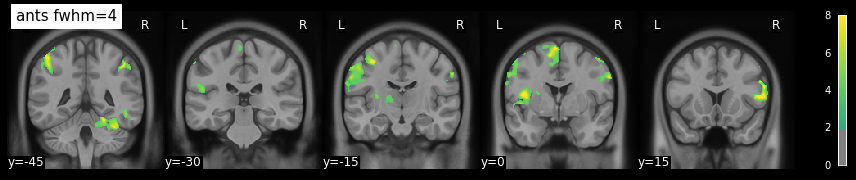

In [13]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0001_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

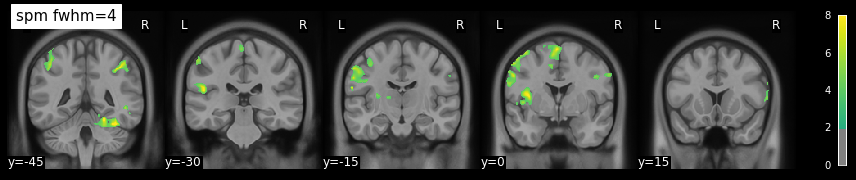

In [14]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/spm_con_0001_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

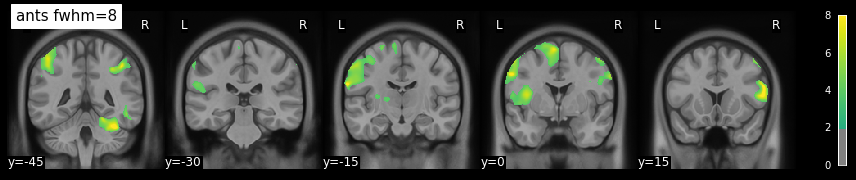

In [15]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0001_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

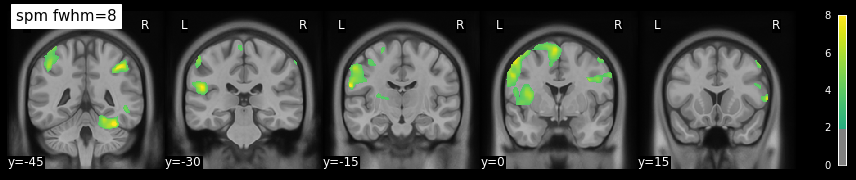

In [16]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/spm_con_0001_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8',
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis');

The results are more or less what you would expect: The peaks are more or less at the same places for the two normalization approaches and a wider smoothing has the effect of bigger clusters, while losing the sensitivity for smaller clusters.

Now, let's see other contrast -- **Finger > others**. Since we removed left-handed subjects, the activation is seen on the left part of the brain.

In [17]:
from nilearn.plotting import plot_stat_map
anatimg = '/home/neuro/Data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

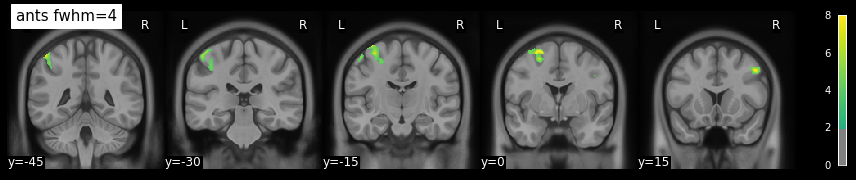

In [18]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15));

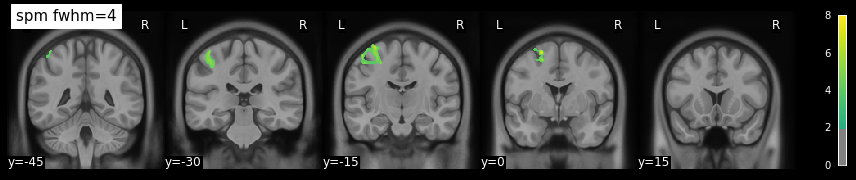

In [19]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15));

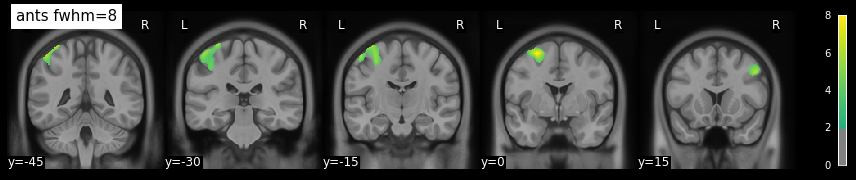

In [20]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15));

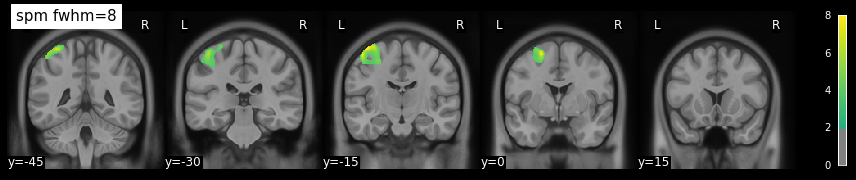

In [21]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15));

Now, let's see the results using the glass brain plotting method.

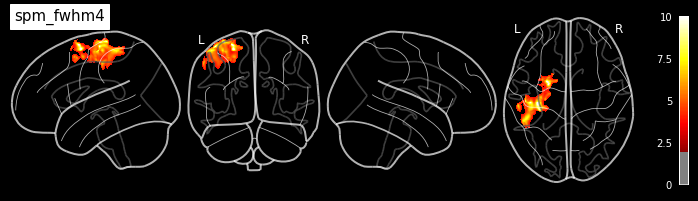

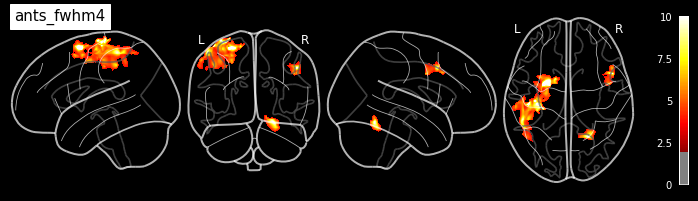

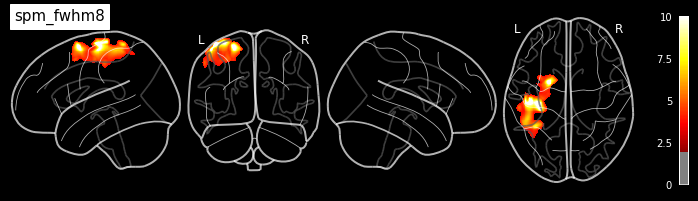

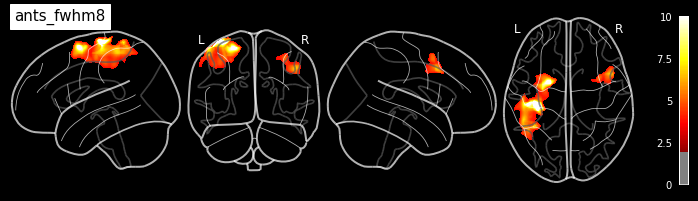

In [22]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm4');
plot_glass_brain(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4');
plot_glass_brain(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm8');
plot_glass_brain(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm8');